# Test Técnico - Inteligencia Artificial

## Información del Dataset (FashionMNIST)

**Mostrar algunos ejemplos del dataset**

In [1]:
img_train = 'train/train-images-idx3-ubyte'
lbs_train = 'train/train-labels-idx1-ubyte'
img_test = 'test/t10k-images-idx3-ubyte'
lbs_test = 'test/t10k-labels-idx1-ubyte'

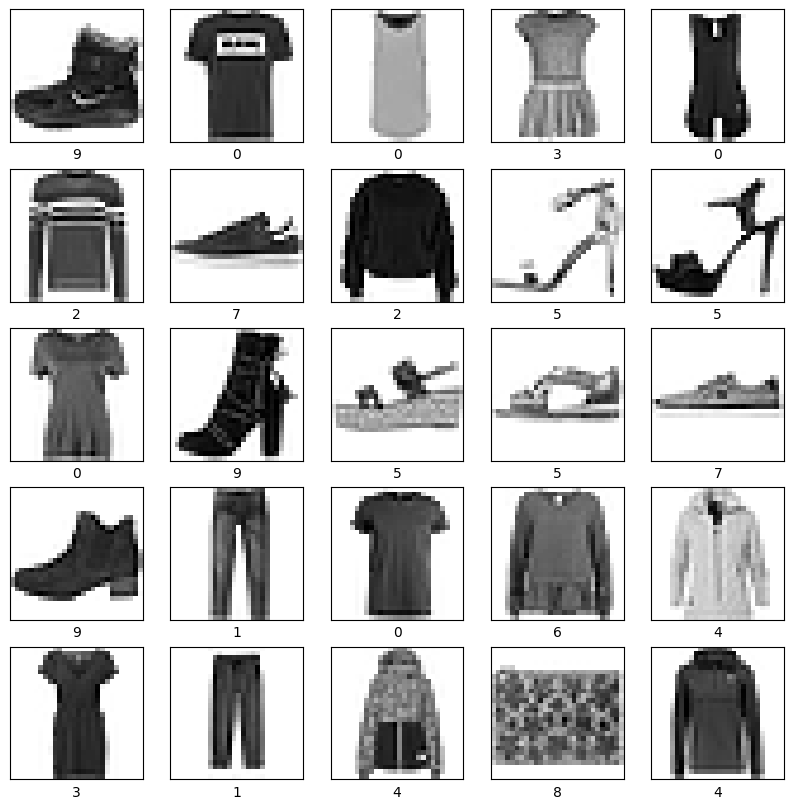

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Funciones para leer archivos IDX
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32).byteswap()
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return data

def read_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_items = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# Cargar datos desde los archivos
train_img = read_images(img_train)
train_lbs = read_labels(lbs_train)
test_img = read_images(img_test)
test_lbs = read_labels(lbs_test)


# Visualizar las imágenes
plt.figure(figsize=(10, 10))
for i in range(25):  # Mostrar las primeras 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i], cmap=plt.cm.binary)  # Mostrar imagen
    plt.xlabel(train_lbs[i])  # Mostrar etiqueta correspondiente
plt.show()


**Tamaño de las imágenes y etiquetas**

In [3]:
print("Train images shape:", train_img.shape)
print("Train labels shape:", train_lbs.shape)
print("Test images shape:", test_img.shape)
print("Test labels shape:", test_lbs.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


/var/folders/9x/tdz37svs2n33397zbw458q3w0000gn/T/ipykernel_895/2911114048.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x='label', data=ydf, order=np.arange(0, 10), ax=ax, palette=colors)


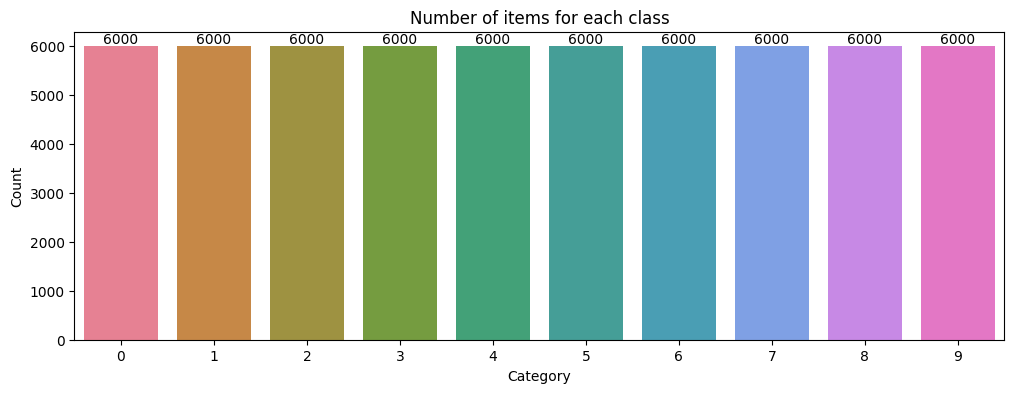

Label     Count     Percentage
------------------------------
0         6000      10.00%
1         6000      10.00%
2         6000      10.00%
3         6000      10.00%
4         6000      10.00%
5         6000      10.00%
6         6000      10.00%
7         6000      10.00%
8         6000      10.00%
9         6000      10.00%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_count_per_class(yd):
    # Convertir las etiquetas en DataFrame
    ydf = pd.DataFrame(yd, columns=['label'])
    f, ax = plt.subplots(1, 1, figsize=(12, 4))
    
    # Definir colores personalizados para cada barra
    colors = sns.color_palette('husl', 10)  # Generar una paleta de 10 colores
    
    # Graficar la distribución de etiquetas
    g = sns.countplot(x='label', data=ydf, order=np.arange(0, 10), ax=ax, palette=colors)
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    g.set_ylabel("Count")
    
    # Anotar los valores encima de las barras
    for p in g.patches:
        height = p.get_height()
        g.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')
    
    plt.show()

def get_count_per_class(yd):
    # Convertir las etiquetas en DataFrame
    ydf = pd.DataFrame(yd, columns=['label'])
    
    # Obtener conteos por clase
    label_counts = ydf['label'].value_counts().sort_index()

    # Total de muestras
    total_samples = len(yd)
    
    # Imprimir el conteo y porcentaje por clase
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print(f"{label:<10}{count:<10}{percent:.2f}%")
    
# Suponiendo que train_lbs tiene 60,000 etiquetas
# Asegúrate de que train_lbs es el arreglo completo de etiquetas de tu dataset

# Pasar las etiquetas a las funciones
plot_count_per_class(train_lbs)
get_count_per_class(train_lbs)

Distribución de etiquetas de los datos de entrenamiento equilibrada, cada prenda de vestir tiene 6000 imágenes de entrenamiento y 1000 imágenes de prueba. Las imágenes son de 28x28 pixeles en escala de grises, con valores de pixel entre 0 y 255. Las etiquetas son enteros entre 0 y 9, correspondientes a las siguientes clases:

Con el objetivo de mejorar la precisión de la clasificación, normalizaremos los valores de los pixeles de las imágenes para que estén en el rango [0, 1]. Esto ayudará a que el modelo converja más rápido.

## Clase ModeloBase

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from seaborn import heatmap
from tensorflow.keras.optimizers import Adam
import csv
from sklearn.metrics import classification_report


class ModeloBase:
    def __init__(self, nombre):
        self.nombre = nombre
        self.modelo = None
    
    def read_images(self, filename):
        # Implementar la lectura de imágenes
        with open(filename, 'rb') as f:
            magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32).byteswap()
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return data

    def read_labels(self, filename):
        # Implementar la lectura de etiquetas
        with open(filename, 'rb') as f:
            magic, num_items = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def preprocesamiento(self, x, y, classes=10, n=28):
        # Normalizar las imágenes y convertir las etiquetas a one-hot encoding
        x = np.reshape(x, (-1, n, n, 1)) 
        x = x.astype('float32') / 255.0 
        y = to_categorical(y, classes) 
        return x, y
    
    def splitData(self, X, y):
        # Dividir los datos utilizando train_test_split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
        # Convertir los arreglos de NumPy a tensores de TensorFlow
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
        return X_train, X_val, y_train, y_val

    def compile(self, lr):
        # Implementar la compilación del modelo
        self.modelo.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    def entrenar(self, X_train, y_train, X_val, y_val, epochs, batch_size, patience=5):
        # Definir Early Stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=patience,  
            restore_best_weights=True 
        )
        
        # Entrenar el modelo con datos de validación
        history = self.modelo.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping]
        )
        return history

    def entrenar_final(self, X_train, y_train, epochs, batch_size):        
        # Entrenar el modelo sin datos de validación
        history = self.modelo.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size
        )
        return history

    def evaluar(self, X_test, y_test):
        # Implementar la evaluación del modelo
        self.modelo.evaluate(X_test, y_test)
        return self.modelo.evaluate(X_test, y_test)
    
    def guardar(self):
        # Implementar el guardado del modelo
        self.modelo.save(f'modelos/{self.nombre}.h5')

    def forward(self, x):
        return self.modelo(x, training=False)
    
    def predict(self, X):
        if self.modelo is None:
            raise ValueError("El modelo no está definido.")
        if not hasattr(self.modelo, 'predict'):
            raise AttributeError("El modelo no tiene el método 'predict'.")
        
        # Genera predicciones
        predicciones = self.modelo.predict(X)
        return predicciones 


    def plot_training_history(self, history):
        # Obtener datos del historial de entrenamiento
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'b', label='Precisión en entrenamiento')
        plt.plot(epochs, val_acc, 'r', label='Precisión en validación')
        plt.title('Precisión en entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')
        plt.legend()
        
        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b', label='Pérdida en entrenamiento')
        plt.plot(epochs, val_loss, 'r', label='Pérdida en validación')
        plt.title('Pérdida en entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()

        plt.show()

    def confusion_matrix(self, X_test, y_test):
        # Implementar la matriz de confusión con seaborn
        y_pred = self.modelo.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        cm = tf.math.confusion_matrix(y_test, y_pred)
        heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.show()

    def guardar_predicciones(self, predicciones, nombre_archivo):
        # Convertir las probabilidades en etiquetas de clase (número del 0 al 9)
        etiquetas = np.argmax(predicciones, axis=1)
        # Guardar las etiquetas en un archivo CSV
        with open(nombre_archivo, mode='w', newline='') as archivo:
            escritor_csv = csv.writer(archivo)
            escritor_csv.writerow(['id', 'label'])  # Encabezados del CSV
            for idx, etiqueta in enumerate(etiquetas, start=60001):  # Empezar el ID en 60001
                escritor_csv.writerow([idx, etiqueta])

    def clasification_report(self, X_test, y_test):
        # Implementar el reporte de clasificación
        y_pred = self.modelo.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        print(classification_report(y_test, y_pred))

## Clase Arquitecturas

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Arquitecturas(ModeloBase):
    def __init__(self, model_type='CNN'):
        super().__init__(model_type)
        self.model_type = model_type
        self.modelo = self.definir_modelo()
        
    def definir_modelo(self):
        if self.model_type == 'CNN':
            return self.cnn_model()
        elif self.model_type == 'LeNet':
            return self.lenet_model()
        elif self.model_type == 'CNNDeep':
            return self.cnn_deep_model()
        elif self.model_type == 'CNN2':
            return self.cnn2_model()
        elif self.model_type == 'CNN3':
            return self.cnn3_model()
        elif self.model_type == 'VGG':  
            return self.vgg_like_model()
        elif self.model_type == 'ResNet':  
            return self.resnet_like_model()
        else:
            raise ValueError(f"Tipo de modelo no reconocido: {self.model_type}")
    
    def cnn_model(self):
        # Modelo básico de CNN
        return tf.keras.models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
    
    def lenet_model(self):
        # Modelo LeNet
        return models.Sequential([
            layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1)),
            layers.AveragePooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            layers.AveragePooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(120, activation='tanh'),
            layers.Dense(84, activation='tanh'),
            layers.Dense(10, activation='softmax')
        ])
    
    def cnn_deep_model(self):
        # Modelo CNN profundo
        return models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])
    
    def cnn2_model(self):
        # Modelo CNN2
        return models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')        
        ])
    
    def cnn3_model(self):
        # Modelo CNN3
        return models.Sequential([
            layers.Conv2D(32, kernel_size=3, padding="same", activation=None, input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Conv2D(64, kernel_size=3, activation=None),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(600, activation='relu'),
            layers.Dropout(0.25),
            layers.Dense(120, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
    
    def vgg_like_model(self):
        # Modelo VGG-like
        return models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])
    
    def resnet_like_model(self):
        # Modelo ResNet-like
        inputs = layers.Input(shape=(28, 28, 1))
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        shortcut = x  # Conexión residual
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])  # Agregar conexión residual
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(10, activation='softmax')(x)
        return models.Model(inputs, outputs)

## Entrenamiento

**Letnet**

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6467 - loss: 1.0017 - val_accuracy: 0.8032 - val_loss: 0.5382
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8102 - loss: 0.5185 - val_accuracy: 0.8312 - val_loss: 0.4633
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8357 - loss: 0.4490 - val_accuracy: 0.8442 - val_loss: 0.4243
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8458 - loss: 0.4183 - val_accuracy: 0.8487 - val_loss: 0.4095
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8614 - loss: 0.3826 - val_accuracy: 0.8600 - val_loss: 0.3801
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8678 - loss: 0.3675 - val_accuracy: 0.8640 - val_loss: 0.3758
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8726 - loss: 0.3520 - val_accuracy: 0.8714 - val_loss: 0.3535
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8772 - loss: 0.3391 - val_accuracy: 0.

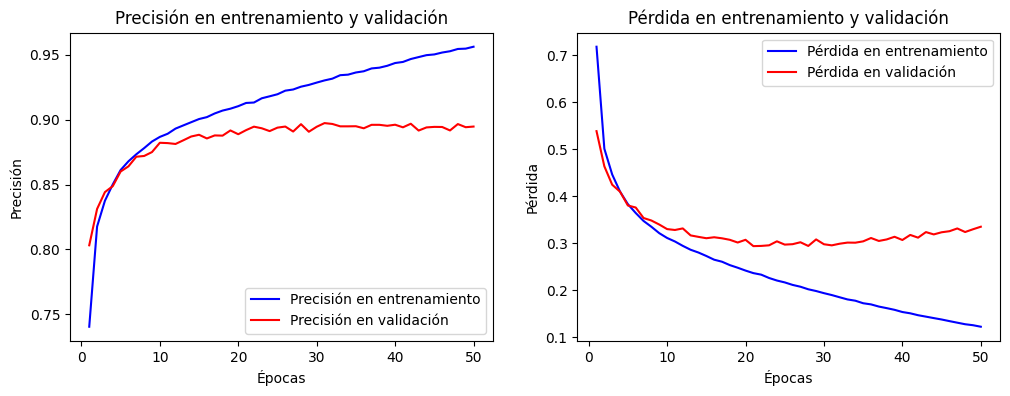

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [14]:
# Instanciar un modelo tipo LeNet
letnet = Arquitecturas(model_type='LeNet')

X_train = letnet.read_images(img_train)
y_train = letnet.read_labels(lbs_train)
X_test = letnet.read_images(img_test)
y_test = letnet.read_labels(lbs_test)
X_train, y_train = letnet.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = letnet.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = letnet.splitData(X_train, y_train)   # dividir datos de entrenamiento 
letnet.compile(lr=0.0005)   # compilar modelo
history = letnet.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = letnet.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
letnet.plot_training_history(history)

predicciones = letnet.predict(X_test)
letnet.guardar_predicciones(predicciones, 'predicciones/letnet_predicts.csv')

# guardar modelo
letnet.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


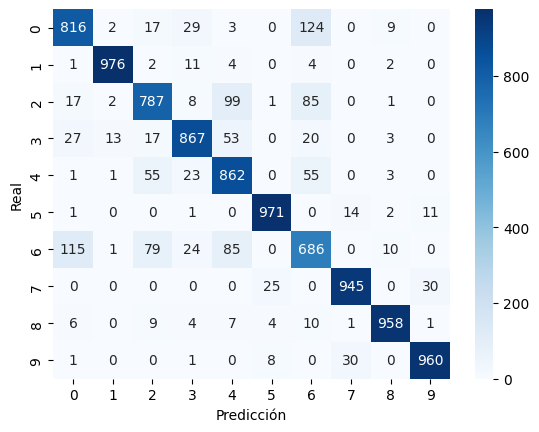

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.79      0.80      1000
           3       0.90      0.87      0.88      1000
           4       0.77      0.86      0.82      1000
           5       0.96      0.97      0.97      1000
           6       0.70      0.69      0.69      1000
           7       0.95      0.94      0.95      1000
           8       0.97      0.96      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [32]:
# confusion_matrix
letnet.confusion_matrix(X_test, y_test)

# clasification_report
letnet.clasification_report(X_test, y_test)

**CNN**

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5582 - loss: 1.3933 - val_accuracy: 0.7667 - val_loss: 0.6290
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7772 - loss: 0.6009 - val_accuracy: 0.7989 - val_loss: 0.5324
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8089 - loss: 0.5243 - val_accuracy: 0.8135 - val_loss: 0.4980
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8281 - loss: 0.4740 - val_accuracy: 0.8336 - val_loss: 0.4506
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8374 - loss: 0.4482 - val_accuracy: 0.8483 - val_loss: 0.4259
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8496 - loss: 0.4222 - val_accuracy: 0.8565 - val_loss: 0.4049
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8594 - loss: 0.3985 - val_accuracy: 0.8599 - val_loss: 0.3929
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8629 - loss: 0.3896 - 

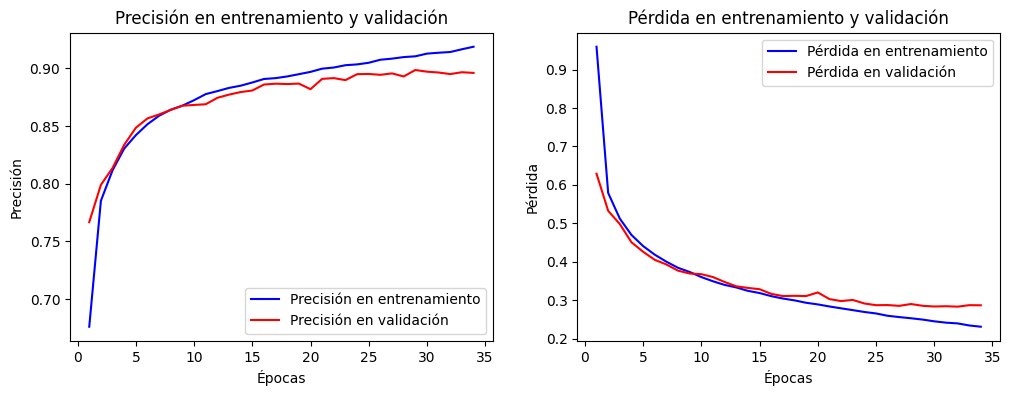

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [30]:
cnn = Arquitecturas(model_type='CNN')
X_train = cnn.read_images(img_train)
y_train = cnn.read_labels(lbs_train)
X_test = cnn.read_images(img_test)
y_test = cnn.read_labels(lbs_test)
X_train, y_train = cnn.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn.compile(lr=0.0001)   # compilar modelo
history = cnn.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn.plot_training_history(history)

predicciones = cnn.predict(X_test)
cnn.guardar_predicciones(predicciones, 'predicciones/cnnDeep_predicts.csv')

# guardar modelo
cnn.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


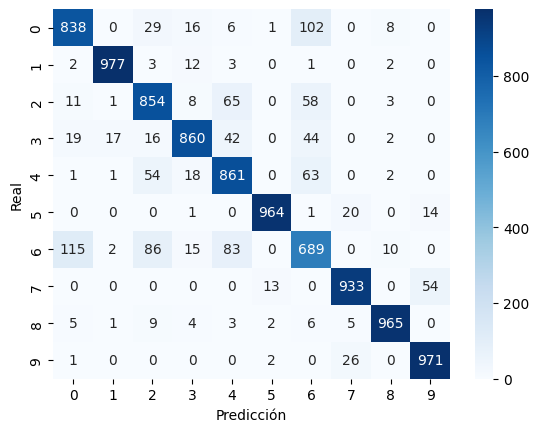

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.85      0.83      1000
           3       0.92      0.86      0.89      1000
           4       0.81      0.86      0.83      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.69      0.70      1000
           7       0.95      0.93      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [33]:
# confusion_matrix
cnn.confusion_matrix(X_test, y_test)

# clasification_report
cnn.clasification_report(X_test, y_test)

**CNN2**

/Users/achula/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6804 - loss: 1.0024 - val_accuracy: 0.8267 - val_loss: 0.4768
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8355 - loss: 0.4564 - val_accuracy: 0.8442 - val_loss: 0.4264
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8565 - loss: 0.4042 - val_accuracy: 0.8624 - val_loss: 0.3829
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8737 - loss: 0.3590 - val_accuracy: 0.8765 - val_loss: 0.3437
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8800 - loss: 0.3341 - val_accuracy: 0.8828 - val_loss: 0.3239
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8864 - loss: 0.3231 - val_accuracy: 0.8829 - val_loss: 0.3198
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8900 - loss: 0.3051 - val_accuracy: 0.8897 - val_loss: 0.3091
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8961 - loss: 0.2919 - 

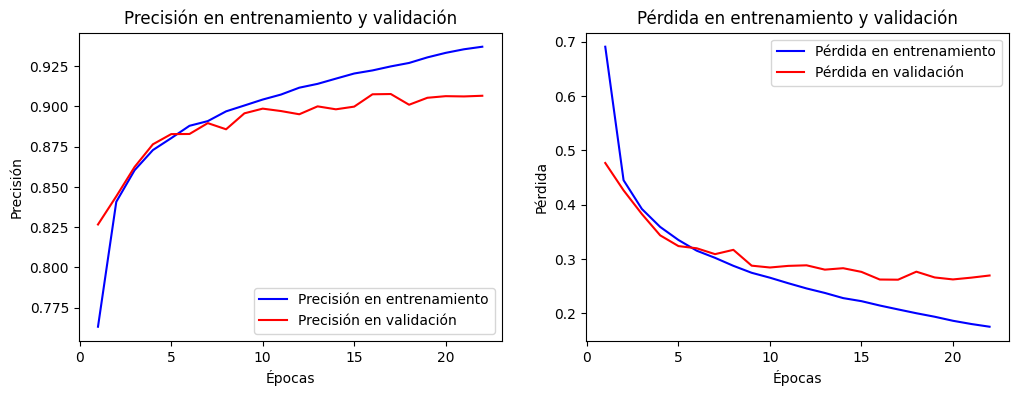

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [35]:
cnn2 = Arquitecturas(model_type='CNN2')
X_train = cnn2.read_images(img_train)
y_train = cnn2.read_labels(lbs_train)
X_test = cnn2.read_images(img_test)
y_test = cnn2.read_labels(lbs_test)
X_train, y_train = cnn2.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn2.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn2.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn2.compile(lr=0.0001)   # compilar modelo
history = cnn2.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn2.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn2.plot_training_history(history)

predicciones = cnn2.predict(X_test)
cnn2.guardar_predicciones(predicciones, 'predicciones/cnn2_predicts.csv')

# guardar modelo
cnn2.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


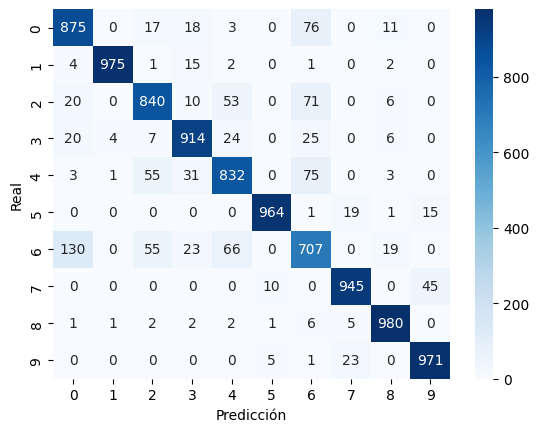

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.84      0.85      1000
           3       0.90      0.91      0.91      1000
           4       0.85      0.83      0.84      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.71      0.72      1000
           7       0.95      0.94      0.95      1000
           8       0.95      0.98      0.97      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [36]:
# confusion_matrix
cnn2.confusion_matrix(X_test, y_test)

# clasification_report
cnn2.clasification_report(X_test, y_test)

**CNN3**

/Users/achula/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.7460 - loss: 0.7104 - val_accuracy: 0.8721 - val_loss: 0.3623
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8744 - loss: 0.3483 - val_accuracy: 0.8905 - val_loss: 0.3072
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8933 - loss: 0.2935 - val_accuracy: 0.8847 - val_loss: 0.3022
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9038 - loss: 0.2648 - val_accuracy: 0.9032 - val_loss: 0.2690
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9149 - loss: 0.2322 - val_accuracy: 0.9056 - val_loss: 0.2573
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9214 - loss: 0.2110 - val_accuracy: 0.9131 - val_loss: 0.2417
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9289 - loss: 0.1940 - val_accuracy: 0.9106 - val_loss: 0.2470
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9339 - loss: 0.1791 - 

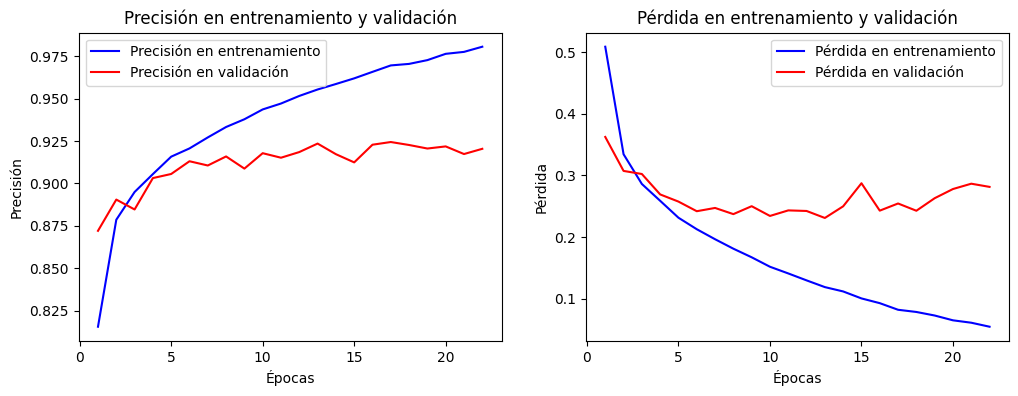

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [38]:
cnn3 = Arquitecturas(model_type='CNN3')
X_train = cnn3.read_images(img_train)
y_train = cnn3.read_labels(lbs_train)
X_test = cnn3.read_images(img_test)
y_test = cnn3.read_labels(lbs_test)
X_train, y_train = cnn3.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn3.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn3.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn3.compile(lr=0.0001)   # compilar modelo
history = cnn3.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn3.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn3.plot_training_history(history)

predicciones = cnn3.predict(X_test)
cnn3.guardar_predicciones(predicciones, 'predicciones/cnn3_predicts.csv')

# guardar modelo
cnn3.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


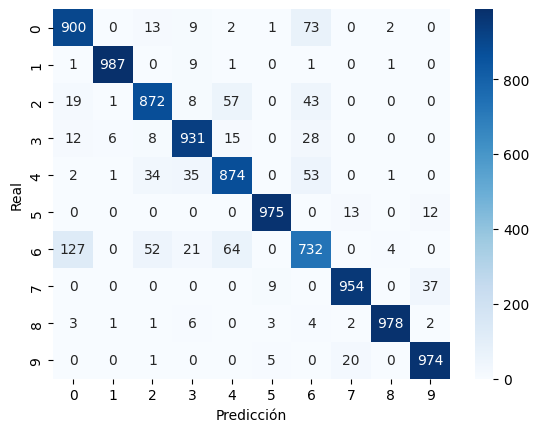

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.89      0.87      0.88      1000
           3       0.91      0.93      0.92      1000
           4       0.86      0.87      0.87      1000
           5       0.98      0.97      0.98      1000
           6       0.78      0.73      0.76      1000
           7       0.96      0.95      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [39]:
# confusion_matrix
cnn3.confusion_matrix(X_test, y_test)

# clasification_report
cnn3.clasification_report(X_test, y_test)

**VGG-Like**

/Users/achula/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 155s 206ms/step - accuracy: 0.6411 - loss: 1.0119 - val_accuracy: 0.8521 - val_loss: 0.4043
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 147s 197ms/step - accuracy: 0.8456 - loss: 0.4223 - val_accuracy: 0.8801 - val_loss: 0.3214
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 154s 206ms/step - accuracy: 0.8735 - loss: 0.3485 - val_accuracy: 0.8899 - val_loss: 0.2928
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 163s 217ms/step - accuracy: 0.8926 - loss: 0.2996 - val_accuracy: 0.8991 - val_loss: 0.2712
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 220ms/step - accuracy: 0.9013 - loss: 0.2709 - val_accuracy: 0.9057 - val_loss: 0.2511
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 151s 202ms/step - accuracy: 0.9071 - loss: 0.2502 - val_accuracy: 0.9082 - val_loss: 0.2452
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 154s 205ms/step - accuracy: 0.9174 - loss: 0.2237 - val_accuracy: 0.9133 - val_loss: 0.2344
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 157s 209ms/step - accuracy: 0.9235 -

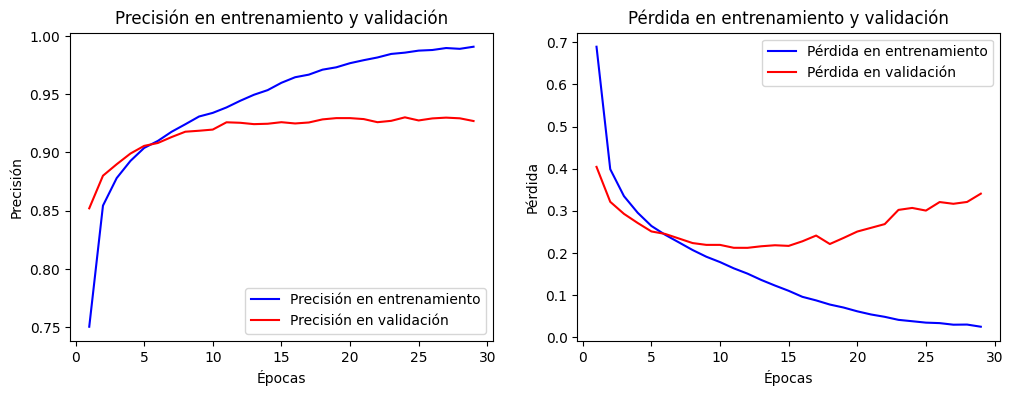

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step


In [29]:
vgg = Arquitecturas(model_type='VGG')
X_train = vgg.read_images(img_train)
y_train = vgg.read_labels(lbs_train)
X_test = vgg.read_images(img_test)
y_test = vgg.read_labels(lbs_test)
X_train, y_train = vgg.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = vgg.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = vgg.splitData(X_train, y_train)   # dividir datos de entrenamiento 
vgg.compile(lr=0.0001)   # compilar modelo
history = vgg.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = vgg.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
vgg.plot_training_history(history)

predicciones = vgg.predict(X_test)
vgg.guardar_predicciones(predicciones, 'predicciones/vgg_predicts.csv')

# guardar modelo
vgg.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


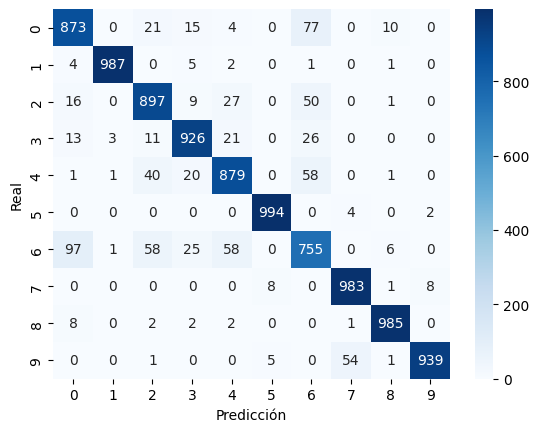

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.87      0.90      0.88      1000
           3       0.92      0.93      0.93      1000
           4       0.89      0.88      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.78      0.76      0.77      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [40]:
# confusion_matrix
vgg.confusion_matrix(X_test, y_test)

# clasification_report
vgg.clasification_report(X_test, y_test)

**ResNet-Like**

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.7353 - loss: 0.8255 - val_accuracy: 0.8751 - val_loss: 0.3384
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.8619 - loss: 0.4003 - val_accuracy: 0.8927 - val_loss: 0.2857
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.8821 - loss: 0.3311 - val_accuracy: 0.9015 - val_loss: 0.2685
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.8977 - loss: 0.2854 - val_accuracy: 0.9115 - val_loss: 0.2431
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.9108 - loss: 0.2546 - val_accuracy: 0.9133 - val_loss: 0.2344
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.9160 - loss: 0.2342 - val_accuracy: 0.9098 - val_loss: 0.2515
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.9232 - loss: 0.2105 - val_accuracy: 0.9177 - val_loss: 0.2320
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.9288 - loss: 0.1897 - 

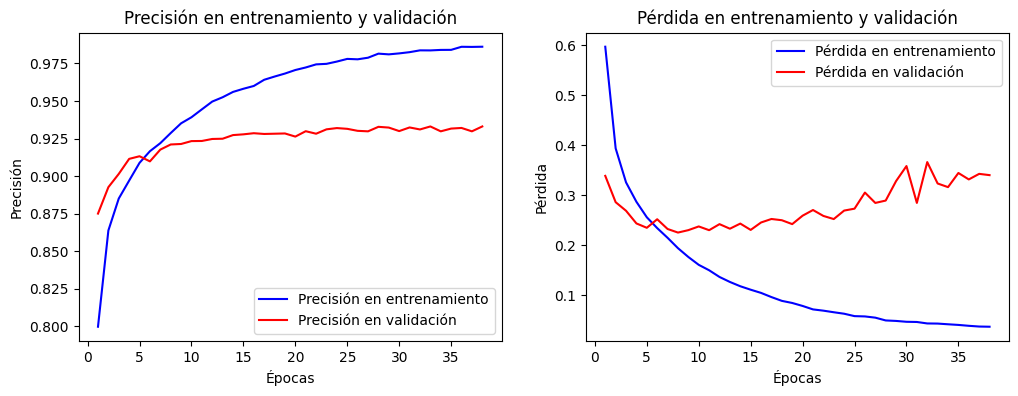

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [27]:
resnet = Arquitecturas(model_type='ResNet')
X_train = resnet.read_images(img_train)
y_train = resnet.read_labels(lbs_train)
X_test = resnet.read_images(img_test)
y_test = resnet.read_labels(lbs_test)
X_train, y_train = resnet.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = resnet.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = resnet.splitData(X_train, y_train)   # dividir datos de entrenamiento 
resnet.compile(lr=0.0001)   # compilar modelo
history = resnet.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = resnet.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
resnet.plot_training_history(history)

predicciones = resnet.predict(X_test)
resnet.guardar_predicciones(predicciones, 'predicciones/resnet_predicts.csv')

# guardar modelo
resnet.guardar()   

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


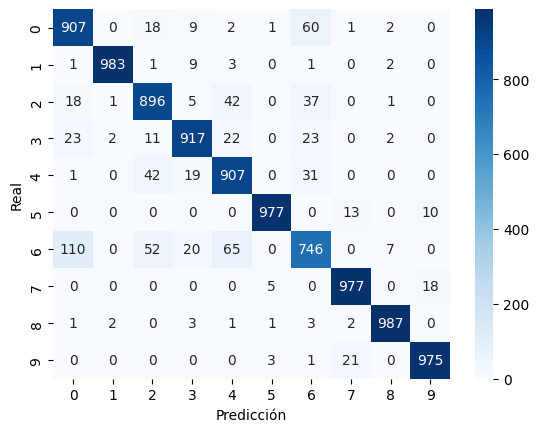

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.90      0.89      1000
           3       0.93      0.92      0.93      1000
           4       0.87      0.91      0.89      1000
           5       0.99      0.98      0.98      1000
           6       0.83      0.75      0.78      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [41]:
# confusion_matrix
resnet.confusion_matrix(X_test, y_test)

# clasification_report
resnet.clasification_report(X_test, y_test)

#### Modelo Final

**El modelo con mejores resultado lo entreno con todos los datos de entrenamiento y validación, y luego lo evalúo con los datos de prueba:**

In [ ]:
resnet_final = Arquitecturas(model_type='ResNet')
X_train = resnet_final.read_images(img_train)
y_train = resnet_final.read_labels(lbs_train)
X_test = resnet_final.read_images(img_test)
y_test = resnet_final.read_labels(lbs_test)
X_train, y_train = resnet_final.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = resnet_final.preprocesamiento(X_test, y_test)       # preprocesamiento test
resnet_final.compile(lr=0.001)   # compilar modelo
history = resnet_final.entrenar_final(X_train, y_train, epochs=30, batch_size=64)   # entrenar modelo
loss, accuracy = resnet_final.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
# cnn2_final.plot_training_history(history)

predicciones = resnet_final.predict(X_test)
resnet_final.guardar_predicciones(predicciones, 'predicciones/resnet_final_predicts.csv')

# guardar modelo
resnet_final.guardar()   

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.6948 - loss: 1.0238
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - accuracy: 0.8298 - loss: 0.4612
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.8565 - loss: 0.3868
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.8798 - loss: 0.3235
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 72s 76ms/step - accuracy: 0.8912 - loss: 0.2976
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8962 - loss: 0.2781
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - accuracy: 0.9015 - loss: 0.2612
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 79ms/step - accuracy: 0.9093 - loss: 0.2435
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.9165 - loss: 0.2284
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.9176 - loss: 0.2185
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - accuracy: 0.9230 - loss: 0.2037
Epoch 12/20
938/938 ━━━━━━━━━━

In [ ]:
# confusion_matrix
resnet_final.confusion_matrix(X_test, y_test)

# clasification_report
resnet_final.clasification_report(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.85      0.92      0.89      1000
           3       0.92      0.94      0.93      1000
           4       0.89      0.87      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.83      0.74      0.78      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.99      0.99      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

